In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

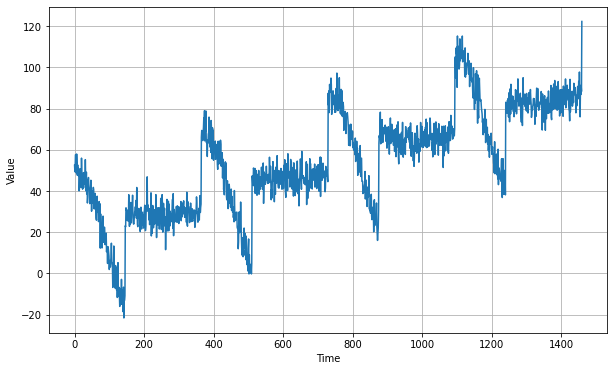

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

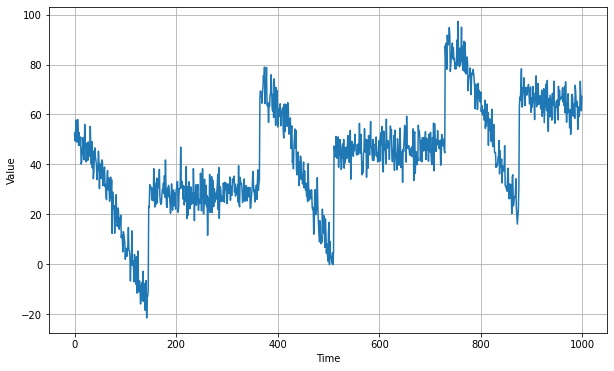

In [5]:
plot_series(time_train, x_train)   

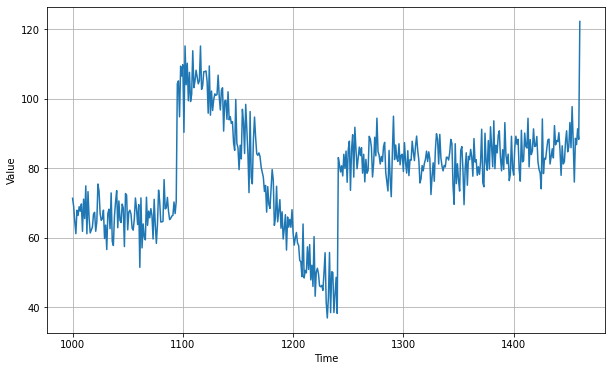

In [6]:
plot_series(time_valid, x_valid)

In [7]:
window_size = 20
batch_size = 32 
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  dataset = dataset.flat_map(lambda window: window.batch(window_size+1)) 

  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  dataset = dataset.shuffle(shuffle_buffer)

  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
for x,y in dataset:
  print(x.numpy(), y.numpy())

[[ 65.38135     69.759796    59.24037     65.01968     60.836647
   70.29547     56.687828    61.493233    66.15852     72.08523
   63.914536    61.453503    73.62201     56.963406    53.19721
   66.379585    61.65801     59.0514      67.68912     65.35661   ]
 [ -8.391326   -14.525443    -7.318105   -14.747516    -2.8571053
  -14.97132    -13.105373    -7.8591013  -18.504087   -11.626857
   -6.6340213  -21.603771   -13.030717   -13.032789   -10.792066
   23.163013    22.696867    31.861048    30.689259    30.41058   ]
 [-21.603771   -13.030717   -13.032789   -10.792066    23.163013
   22.696867    31.861048    30.689259    30.41058     30.84493
   25.66792     30.18544     30.446434    25.366972    38.226013
   31.225473    22.859697    32.05963     23.86483     32.63576   ]
 [ 30.793396    25.17319     29.614908    34.90301     26.434551
   33.833897    12.305289    28.903387    24.615705    22.06895
   23.403429    12.384742    20.599699    22.856821    27.831846
   17.22026     15.

In [11]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [12]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

model = tf.keras.models.Sequential([l0])

print("Layer weights: \n {} \n".format(l0.get_weights()))


Layer weights: 
 [array([[ 0.2946481 ],
       [ 0.2024948 ],
       [-0.06639209],
       [ 0.1587711 ],
       [ 0.08810765],
       [ 0.23585337],
       [ 0.18339711],
       [ 0.4579574 ],
       [-0.20957088],
       [-0.09136933],
       [ 0.11233157],
       [-0.14813459],
       [-0.15615681],
       [-0.14070621],
       [ 0.22831136],
       [ 0.38533676],
       [ 0.453955  ],
       [-0.2562081 ],
       [ 0.28685415],
       [ 0.46536928]], dtype=float32), array([0.], dtype=float32)] 



In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model.fit(dataset, epochs=100, verbose=0)

In [15]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.02679667],
       [ 0.00734307],
       [-0.00401224],
       [-0.00418742],
       [ 0.00381088],
       [ 0.015617  ],
       [-0.00597993],
       [ 0.07008138],
       [-0.06944655],
       [ 0.00232799],
       [ 0.0285399 ],
       [-0.0063083 ],
       [-0.05893993],
       [ 0.00348625],
       [ 0.03966367],
       [ 0.10159953],
       [ 0.07535532],
       [ 0.06793344],
       [ 0.2767213 ],
       [ 0.47128573]], dtype=float32), array([0.01085281], dtype=float32)]


In [16]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[1:21][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
model prediction: [[49.146114]]


In [17]:
forecast = []

# Use the model to predict data points per window size

for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

# Slice the points that are aligned with the validation set

forecast = forecast[split_time-window_size:]

print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')


length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461,)
shape after squeezing: (461,)


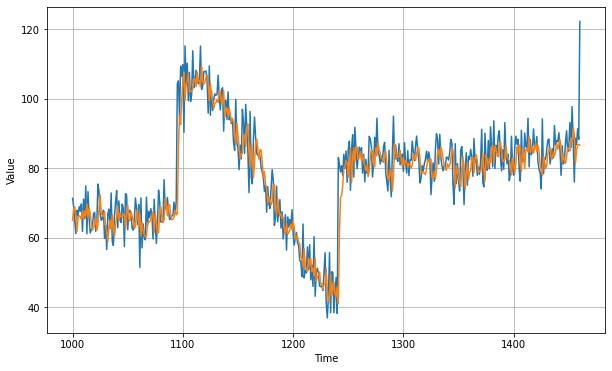

In [19]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze() #[:,0,0]

plot_series(time_valid, (x_valid, results))

In [20]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

5.0261426
46.629204
